In [1]:
# LOGGING CALLS REPLACED WITH NORMAL PRINTS

import os
from datetime import datetime

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

BLUE = "\033[34m"
RESET = "\033[0m"
UPLOAD_FOLDER = os.path.join(os.getcwd(), 'uploads')

In [2]:
def saveimg_cv(scan_type, img):
    rn = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"scan-{scan_type}-{rn}.png"
    cv.imwrite(str(os.path.join(UPLOAD_FOLDER,filename)), img)
    return {
        "name":filename,
        "scan_type":scan_type
    }

def plot_img(img, saveImage):
    fig,ax = plt.subplots()
    plt.axis('off')
    rgb_img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    ax.imshow(rgb_img)
    if saveImage:
        plt.savefig('output_image.png', bbox_inches='tight', pad_inches=0)
    plt.show()

In [3]:
def getAngle(p1, p2, p3):
    #get vectors
    a = np.array(p1) - np.array(p2)
    b = np.array(p3) - np.array(p2)
    a_mag = (a[0]**2+a[1]**2)**(1/2)
    b_mag = (b[0]**2+b[1]**2)**(1/2)
    dot = np.dot(a,b)
    # using formula: cos(theta) = (u dot v) / |u||v|
    cosine = dot/(a_mag*b_mag + 1e-8) #1e-8 used to balance div by 0
    angle = np.arccos(np.clip(cosine,-1.0,1.0)) #sometimes result is outside of [-1,1], so adjust it and feed it to arccos
    deg = angle/np.pi*180 #convert to degrees
    return deg

def cross2d(vec_a, vec_b):
    return vec_a[0]*vec_b[1] - vec_a[1]*vec_b[0]

def order_corners(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = np.sum(pts, axis=1)
    d = np.diff(pts, axis=1)

    rect[0] = pts[np.argmin(s)]  # top-left - min of x+y
    rect[2] = pts[np.argmax(s)]  # bottom-right - max of x+y
    rect[1] = pts[np.argmin(d)]  # top-right - min of x-y
    rect[3] = pts[np.argmax(d)]  # bottom-left - max of x+y

    return rect

def around(value, target, thresh):
    #let thresh be a percent of error
    return target*(1 - thresh) <= value <= target*(1 + thresh)

In [4]:
def mark_corners(img,contour):
    annotated = np.copy(img)

    # resize current contour
    closed_pts = [i[0] for i in contour]

    # tracking corners marked
    marked = [0 for i in closed_pts]

    # compute markable corners along contour 
    for ind in range(2, len(closed_pts)+2):
        i = ind%len(closed_pts)

        # POINTS LABEL
        #cv.putText(img,str(closed_pts[i]),[closed_pts[i][0],closed_pts[i][1]+(30 if i%3==0 else (-30 if i%3==1 else 0))],cv.FONT_HERSHEY_PLAIN,1,(255,255,255))
        # DRAW COLORED LINES
        #cv.line(img,closed_pts[i-1],closed_pts[i],(255 if i%3==0 else 0,255 if i%3==1 else 0,255 if i%3==2 else 0),3)

        angle = getAngle(closed_pts[i-2],closed_pts[i-1],closed_pts[i])
        # ANGLE READOUT DISPLAY
        #cv.putText(img,str(angle)[:6],[closed_pts[i][0],closed_pts[i][1]+(30 if i%3==0 else (-30 if i%3==1 else 0))],cv.FONT_HERSHEY_PLAIN,1,(255,255,255))

        print("x  y  angle")
        print(str(closed_pts[i][0]) + " " +
              str(closed_pts[i][1]) + " " +
              str(angle))

        #mark points only if they are along an edge - ie a point that has ~180 degree angle
        if abs(angle-180)<10:
            print(f"marking {closed_pts[i]} and {closed_pts[i-1]} and {closed_pts[i-2]}")
            #mark the point center to the angle
            marked[i-1]=1

    # points marked are in the middle of line segs, and
    # all points not marked are parts of corners
    # thus gather points NOT MARKED
    pot_corners = []
    for i in range(len(marked)):
        if marked[i] == 0:
            pot_corners.append(closed_pts[i])

    #draw circle on the potential points
    for i in range(len(pot_corners)):
        #cv.putText(img, str(pot_corners[i]), [pot_corners[i][0], pot_corners[i][1]+(30 if i%3==0 else (-30 if i%3==1 else 0))], cv.FONT_HERSHEY_PLAIN, 1, (255, 255, 255))
        cv.circle(annotated, tuple(map(int, pot_corners[i])), 10, (0, 255, 255), -1) #yellow dot
    
    plot_img(annotated,False)
    
    return pot_corners

In [5]:
def find_corners(annotated, potential_corners):
    #process to find 4 corners
    # many potential corners are marked, but we wanna isolate 4 ones - the points in the center of a bunch of marked corners in a real corner
    # 250606 note: this alg is largely inefficient calculating dists and a mean across n
    #              and then looping over n + (small) k<n
    #              even tho its tech O(n) its rly like 3*n and n doesnt get super duper large so yeah o well
    corner_start,corner_end = -1,-1
    corner_indexes = set()
    dists = []
    #find distances between points to isolate those that are nearby
    #find average distance as threshold for later use
    for i in range(1, len(potential_corners)):
        dists.append(np.linalg.norm(np.array(potential_corners[i]) - np.array(potential_corners[i - 1])))
    dists.sort()
    avg = np.mean(dists[0:int(len(dists) * 3 / 4)])
    # im p sure statistically, the outliers are so big that if we avg the lower 3 quartiles we are still chill
    #plt.plot(dists, "ro")
    #plt.show()

    ind, offset = 0,0
    while ind < len(potential_corners)+offset+1:
        # i is the modded version to allow loopback of the loop and guarantee a full cycle where we hit every corner
        # ind is the actual loop, and its used when doing ind calc for accurate calcs w/o loopback issue
        # +1 required cuz the alg works by running midpt calc when u reach i+1 (cuz it then calcs curr index - 1 for midpt)
        i = ind%len(potential_corners)

        #get the vector betw pts, then get their magnitude (length) with linalg.norm
        curr_dist = np.linalg.norm(np.array(potential_corners[i]) - np.array(potential_corners[i - 1]))
        print(
            f'''point {potential_corners[i]}\ndist {curr_dist}''')

        # FIND when distance between adj points is large in order to isolate groups of points at a corner
        if curr_dist - avg > 10:
            # when we encounter small dist, its like 0.8 - 0.5 (curr_dist - avg) --> less than 5 fo sho
            # if the curr dist is small, then minus avg will guarantee negative
            #means that 10 is lowk arbitrary and just needs to check for negative
            # thus if its >5, then its a large distance
            if corner_start==-1:
                # if start == -1, then establish st point on encountering a large dist
                corner_start=ind
                print(f"starting at {corner_start}")
                offset=ind

            else:
                # now once you find another large dist, there will be a corner inside
                # (ie if large dist and start != -1)

                #   calc midpt - to i-1
                midpt = int(((ind-1)+corner_start)/2)%len(potential_corners)
                print(f"midpt at {midpt}")

                # add calc'd corner to list of corners (tracked by index)
                    # its a set btw - ensures no duplicates
                corner_indexes.add(midpt)
                #draw circle on the finalized corner
                cv.circle(annotated, tuple(map(int, potential_corners[midpt])), 10, (255, 0, 0), -1)  # blue dot

                #   set start to i
                corner_start = ind
                print(f"start again at {i}")
        ind+=1
        print()

    plot_img(annotated,False)
    
    return corner_indexes

In [6]:
def cut_to_object(og_img, potential_corners, corner_indexes):
    # given corners, flatten and push frame to these 4 corners

    # find destination box
    corner_indexes = sorted(list(corner_indexes)) #REMEMBER: ITEMS IN CORNERS ARE INDEXES OF POT_CORNERS
    corners = [potential_corners[i] for i in corner_indexes]
    if len(corners)!=4:
        print("ERROR: LESS THAN 4 CORNERS WERE DETERMINED")
        return None
    else:
        corners = np.array(corners, dtype=np.float32)
        corners = order_corners(corners)
        print("corners are: ",corners)
        u = corners[1] - corners[0]
        v = corners[2] - corners[1]
        w = corners[3] - corners[2]
        a = corners[0] - corners[3]
        #use the formula - it yields an aspect ratio length:width for the resized rectangle
        #UPDATE: FORMULA NO WORK
        #ratio = (1/2)*(cross2d(u,v)+cross2d(w,a))/(np.linalg.norm(u)+np.linalg.norm(v)+np.linalg.norm(w)+np.linalg.norm(a))**2
        #length = np.linalg.norm(u)
        #width = length/ratio
        #print(ratio)

        #compute destination size and mat
        length = max(np.linalg.norm(u),np.linalg.norm(w))
        width = max(np.linalg.norm(v),np.linalg.norm(a))
        dst = np.array([[0.0,0.0],[length,0.0],[length,width],[0.0,width]], dtype=np.float32)
        print(length,width)

        #get transformation
        M = cv.getPerspectiveTransform(corners, dst)
        img_resized = cv.warpPerspective(og_img, M, (int(length), int(width)))
        
        plot_img(img_resized, False)
        return img_resized

In [7]:
img = cv.imread("test.png")

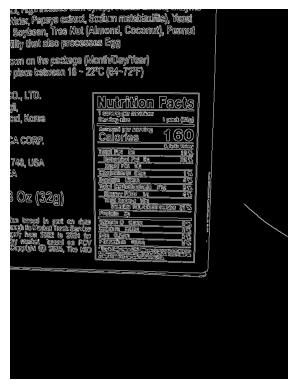

In [8]:
edges = cv.Canny(img,100,200)
plot_img(edges, False)

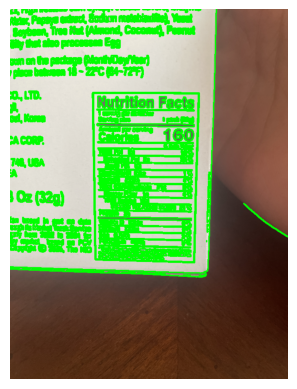

In [9]:
annotated_contours = np.copy(img)
contours, _ = cv.findContours(edges.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(annotated_contours,contours,-1,(0,255,0),2)
plot_img(annotated_contours, False)

In [275]:
all_objs = [] #all contours
all_objs_areas = [] # areas of all contours
pos_objs = [] # biggest contours
for c in contours:
    closed = cv.convexHull(c)
    closed_area = cv.contourArea(closed)
    all_objs.append(closed)
    all_objs_areas.append(closed_area)
    #for now, use 10e4; problems in future may arise where its necessary to access the top 5 or so biggest contours
    if closed_area > 1e4:
        pos_objs.append(closed)

if len(pos_objs)==0:
    print("WARN: no significantly large contours detected")

800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0
800 1000.0

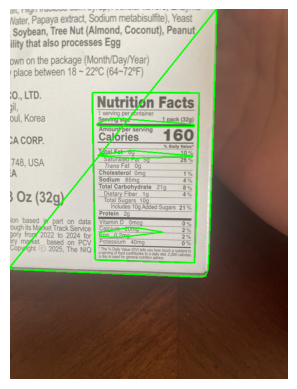

In [276]:
#take the first 1 biggest objects instead
annotated_final = np.copy(img)
swaps=list(range(len(all_objs_areas)))
swaps.sort(key=lambda ind: all_objs_areas[ind], reverse=True)
for i in range(5):
    pos_objs.append(all_objs[swaps[i]])

cv.drawContours(annotated_final, pos_objs, -1, (0,255,0), 2)
plot_img(annotated_final,False)

finding potential corners
x  y  angle
443 97 179.85494758893623
marking [443  97] and [444  55] and [445   8]
x  y  angle
442 138 179.9667459313714
marking [442 138] and [443  97] and [444  55]
x  y  angle
441 174 179.80604064151422
marking [441 174] and [442 138] and [443  97]
x  y  angle
439 235 179.71326277182357
marking [439 235] and [441 174] and [442 138]
x  y  angle
429 522 179.8823161156566
marking [429 522] and [439 235] and [441 174]
x  y  angle
427 561 179.05988786617334
marking [427 561] and [429 522] and [439 235]
x  y  angle
426 566 171.62574095285447
marking [426 566] and [427 561] and [429 522]
x  y  angle
423 574 170.75388717364913
marking [423 574] and [426 566] and [427 561]
x  y  angle
422 576 173.99099375760065
marking [422 576] and [423 574] and [426 566]
x  y  angle
421 577 161.56505063352247
x  y  angle
418 578 153.4349485666875
x  y  angle
414 579 175.60129407373427
marking [414 579] and [418 578] and [421 577]
x  y  angle
402 579 165.96375648575264
x  y  angle

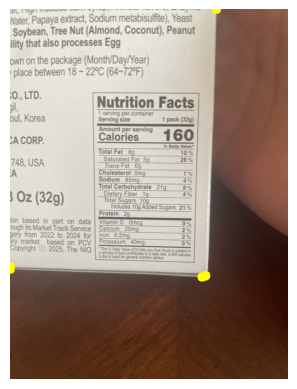

getting actual corners
point [422 576]
dist 576.4590184913408
starting at 0

point [421 577]
dist 1.4142135623730951

point [414 579]
dist 7.280109889280518

point [  0 562]
dist 414.348886809172
midpt at 1
start again at 3

point [  0 557]
dist 5.0

point [445   0]
dist 712.9333769715091
midpt at 3
start again at 5

point [422 576]
dist 576.4590184913408
midpt at 5
start again at 0



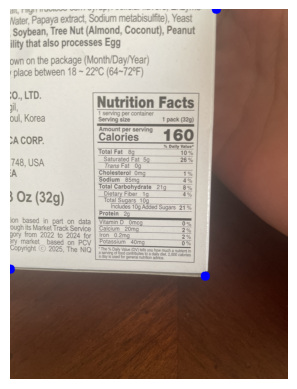

corner indexes are:  {1, 3, 5}
cutting object
ERROR: LESS THAN 4 CORNERS WERE DETERMINED
toast

~~~~~~~~~~~~~~~~~~~~~~~~~~~



finding potential corners
x  y  angle
443 97 179.85494758893623
marking [443  97] and [444  55] and [445   8]
x  y  angle
442 138 179.9667459313714
marking [442 138] and [443  97] and [444  55]
x  y  angle
441 174 179.80604064151422
marking [441 174] and [442 138] and [443  97]
x  y  angle
439 235 179.71326277182357
marking [439 235] and [441 174] and [442 138]
x  y  angle
429 522 179.8823161156566
marking [429 522] and [439 235] and [441 174]
x  y  angle
427 561 179.05988786617334
marking [427 561] and [429 522] and [439 235]
x  y  angle
426 566 171.62574095285447
marking [426 566] and [427 561] and [429 522]
x  y  angle
423 574 170.75388717364913
marking [423 574] and [426 566] and [427 561]
x  y  angle
422 576 173.99099375760065
marking [422 576] and [423 574] and [426 566]
x  y  angle
421 577 161.56505063352247
x  y  angle
418 578 153.4349485666875
x  y  an

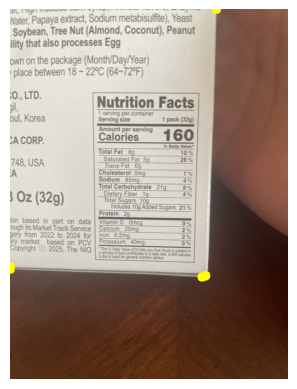

getting actual corners
point [422 576]
dist 576.4590184913408
starting at 0

point [421 577]
dist 1.4142135623730951

point [414 579]
dist 7.280109889280518

point [  0 562]
dist 414.348886809172
midpt at 1
start again at 3

point [  0 557]
dist 5.0

point [445   0]
dist 712.9333769715091
midpt at 3
start again at 5

point [422 576]
dist 576.4590184913408
midpt at 5
start again at 0



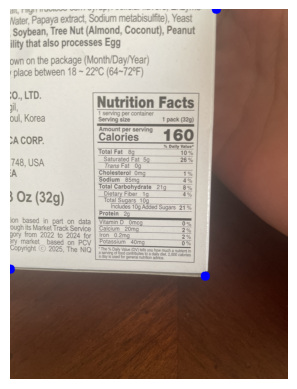

corner indexes are:  {1, 3, 5}
cutting object
ERROR: LESS THAN 4 CORNERS WERE DETERMINED
toast

~~~~~~~~~~~~~~~~~~~~~~~~~~~



finding potential corners
x  y  angle
398 548 179.03922401495444
marking [398 548] and [399 526] and [408 212]
x  y  angle
372 548 92.60256220245434
x  y  angle
200 543 178.33489393749076
marking [200 543] and [372 548] and [398 548]
x  y  angle
184 542 178.08877167688198
marking [184 542] and [200 543] and [372 548]
x  y  angle
183 540 120.14138554279462
x  y  angle
182 511 155.40988281450788
x  y  angle
178 259 178.9344464341049
marking [178 259] and [182 511] and [183 540]
x  y  angle
177 191 179.9331437828873
marking [177 191] and [178 259] and [182 511]
x  y  angle
177 183 179.1574756676478
marking [177 183] and [177 191] and [178 259]
x  y  angle
178 180 161.56505110913355
x  y  angle
368 180 108.43494882260414
x  y  angle
408 181 178.56790381282116
marking [408 181] and [368 180] and [178 180]
x  y  angle
408 212 91.43209618415311
x  y  angle
399 526 178

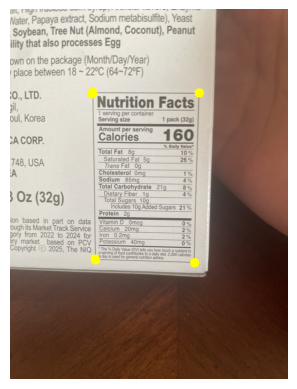

getting actual corners
point [398 548]
dist 367.1362145035545
starting at 0

point [184 542]
dist 214.0840956259946
midpt at 0
start again at 1

point [183 540]
dist 2.23606797749979

point [177 183]
dist 357.0504166080751
midpt at 1
start again at 3

point [178 180]
dist 3.1622776601683795

point [408 181]
dist 230.0021739027699
midpt at 3
start again at 5

point [398 548]
dist 367.1362145035545
midpt at 5
start again at 0



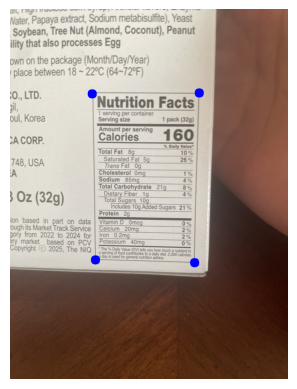

corner indexes are:  {0, 1, 3, 5}
cutting object
corners are:  [[177. 183.]
 [408. 181.]
 [398. 548.]
 [184. 542.]]
231.00865 367.1362


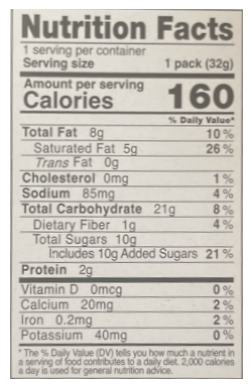


~~~~~~~~~~~~~~~~~~~~~~~~~~~



finding potential corners
x  y  angle
397 253 94.50490686353884
x  y  angle
396 254 134.9999998987144
x  y  angle
319 254 134.99999999473843
x  y  angle
198 253 179.526491933823
marking [198 253] and [319 254] and [396 254]
x  y  angle
188 252 174.76291491609507
marking [188 252] and [198 253] and [319 254]
x  y  angle
187 250 122.27564429847472
x  y  angle
187 249 153.43494831045297
x  y  angle
188 247 153.43494831045297
x  y  angle
220 236 135.53545897784923
x  y  angle
232 236 161.0295921874086
x  y  angle
397 249 175.49509313273148
marking [397 249] and [232 236] and [220 236]


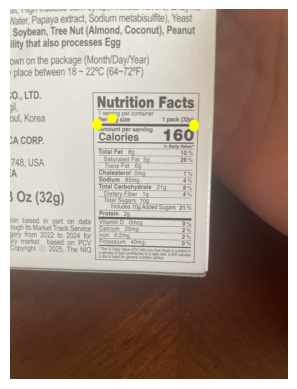

getting actual corners
point [397 249]
dist 177.47675904185314
starting at 0

point [397 253]
dist 4.0

point [396 254]
dist 1.4142135623730951

point [188 252]
dist 208.00961516237658
midpt at 1
start again at 3

point [187 250]
dist 2.23606797749979

point [187 249]
dist 1.0

point [188 247]
dist 2.23606797749979

point [220 236]
dist 33.83784863137726
midpt at 4
start again at 7

point [397 249]
dist 177.47675904185314
midpt at 7
start again at 0



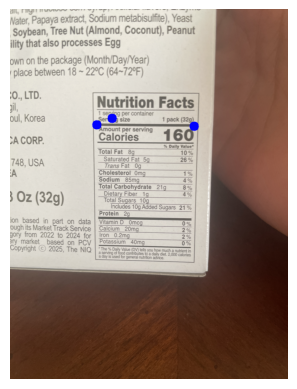

corner indexes are:  {1, 4, 7}
cutting object
ERROR: LESS THAN 4 CORNERS WERE DETERMINED
toast

~~~~~~~~~~~~~~~~~~~~~~~~~~~



finding potential corners
x  y  angle
190 317 174.67956944661512
marking [190 317] and [261 322] and [394 319]
x  y  angle
190 315 94.0282636662017
x  y  angle
263 306 97.02839623846941
x  y  angle
267 306 172.9716037452545
marking [267 306] and [263 306] and [190 315]
x  y  angle
394 317 175.049727752735
marking [394 317] and [267 306] and [263 306]
x  y  angle
394 319 94.9502722340971
x  y  angle
261 322 91.29216688620134


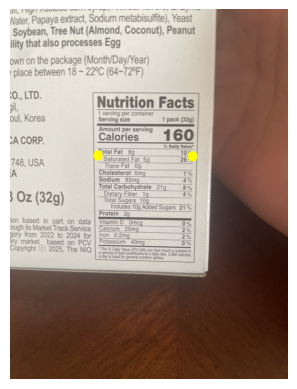

getting actual corners
point [394 319]
dist 2.0

point [190 317]
dist 204.00980368599937
starting at 1

point [190 315]
dist 2.0

point [394 317]
dist 204.00980368599937
midpt at 1
start again at 3

point [394 319]
dist 2.0

point [190 317]
dist 204.00980368599937
midpt at 3
start again at 1



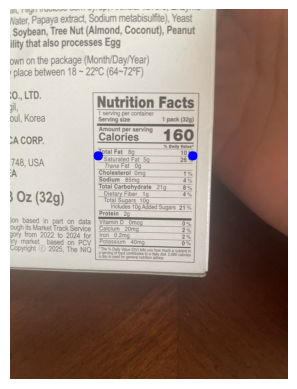

corner indexes are:  {1, 3}
cutting object
ERROR: LESS THAN 4 CORNERS WERE DETERMINED
toast

~~~~~~~~~~~~~~~~~~~~~~~~~~~



finding potential corners
x  y  angle
232 493 172.95423086867083
marking [232 493] and [240 493] and [329 482]
x  y  angle
193 492 178.53119921401802
marking [193 492] and [232 493] and [240 493]
x  y  angle
193 484 91.46880071433876
x  y  angle
195 482 134.99999997467862
x  y  angle
257 472 144.16234704125552
x  y  angle
277 473 167.97524772602765
x  y  angle
329 482 173.0431045829106
marking [329 482] and [277 473] and [257 472]
x  y  angle
240 493 16.865069764024707


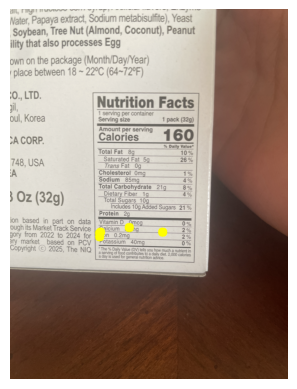

getting actual corners
point [329 482]
dist 72.69112738154499
starting at 0

point [193 492]
dist 136.36715146984628
midpt at 0
start again at 1

point [193 484]
dist 8.0

point [195 482]
dist 2.8284271247461903

point [257 472]
dist 62.80127387243033
midpt at 2
start again at 4

point [329 482]
dist 72.69112738154499
midpt at 4
start again at 0



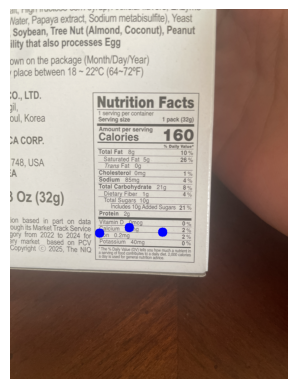

corner indexes are:  {0, 2, 4}
cutting object
ERROR: LESS THAN 4 CORNERS WERE DETERMINED
toast

~~~~~~~~~~~~~~~~~~~~~~~~~~~





In [17]:
valid_images = []

for ob in pos_objs:
    #ob is a contour
    print(f"{BLUE}finding potential corners{RESET}")
    pot_corners = mark_corners(img,ob)

    print(f"{BLUE}getting actual corners{RESET}")
    annotated = np.copy(img)
    corner_inds = find_corners(annotated,pot_corners)
    print("corner indexes are: ",corner_inds)

    if corner_inds is None:
        print("toast")

    print(f"{BLUE}cutting object{RESET}")
    final_img = cut_to_object(img, pot_corners, corner_inds)
    if final_img is None:
        print("toast")
    else:
        valid_images.append(final_img)
        
    print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n\n")

In [13]:
#IN THE FUTURE make this so that the object with most process text (that isnt whitespace) is dominant in being the final processed image
#IN THE FUTURE also include columns scanned

In [253]:
def get_ypos_lines(thresh_img):
    
    annotated = np.copy(thresh_img)
    annotated = cv.cvtColor(annotated,cv.COLOR_GRAY2BGR)

    edges = cv.Canny(annotated,50,200)
    plot_img(edges,False)

    lines = cv.HoughLines(edges,1,np.pi/180,200)
    values = set()
    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        img_height = thresh_img.shape[0]
        
        line_straightness_threshold = 0.01
        if abs(y2-y1)/img_height < line_straightness_threshold:
            values.add(y2)

        cv.line(annotated,(x1,y1),(x2,y2),(0,0,255),2)
    plot_img(annotated,False)
    
    #annotated = np.copy(thresh_img)
    #annotated = cv.cvtColor(annotated,cv.COLOR_GRAY2BGR)
    #cv.drawContours(annotated,contours,-1,(0,255,0),2)
    #plot_img(annotated,False)
    
    return list(values)

In [272]:
def get_cut_rows(img,line_positions):
    line_positions = sorted(line_positions)

    rows = []
    height = img.shape[0]
    for i in range(len(line_positions) - 1):
        
        row_size_offset_threshold = 0.005
        offset = int(height*row_size_offset_threshold)
        
        top = line_positions[i]
        bottom = line_positions[i+1]
        
        abs_row_height_threshold = 20
        if abs(top-bottom) < abs_row_height_threshold:
            # if the row is too short, dont consider it
            continue
        
        top -= offset
        bottom += offset
        width_constraint_threshold = 10
        
        row_crop = img[top:bottom, width_constraint_threshold:-width_constraint_threshold]
        rows.append(row_crop)
    
    return rows

In [ ]:
def process_img_to_thresh(img):

    # size up for better ocr
    scale_factor = 3.0
    new_size = (int(img.shape[1] * scale_factor), int(img.shape[0] * scale_factor))

    # Resize the image using cv2
    resized_img = cv.resize(img, new_size, interpolation=cv.INTER_CUBIC)

    t1 = cv.getTickCount() #for processing time

    # turn image grayscale
    gray = cv.cvtColor(resized_img, cv.COLOR_BGR2GRAY)

    # apply blur
    #blur = cv.GaussianBlur(gray,(5,5),0)

    #upscaled image is inherently noisier - remove large noise
    denoise = cv.fastNlMeansDenoising(gray, h=17)

    # binarize image
    thresh = cv.adaptiveThreshold(denoise,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
    #_,otsuThresh = cv.threshold(denoise,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    return thresh

In [273]:
def scan_text(img):
    
    thresh = process_img_to_thresh(img)
    
    # get horizontal lines
    line_pos = get_ypos_lines(thresh)
    rows = get_cut_rows(thresh,line_pos)
    
    detected_text = []
    for i in range(len(rows)):
        # fill in gaps by shaving back the whites with erosion
        kernel = np.ones((2,2),np.uint8)
        erode = cv.erode(rows[i],kernel,iterations = 1)
        plot_img(erode,False)
        
        final = erode
        detected_text.append(pytesseract.image_to_string(final))

    print("finished")
    print("elapsed: "+str((cv.getTickCount()-t1)/cv.getTickFrequency()))
    
    return detected_text

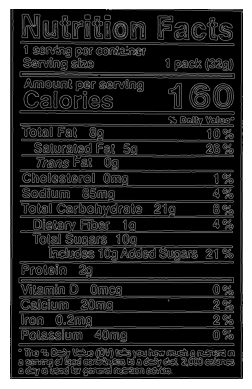

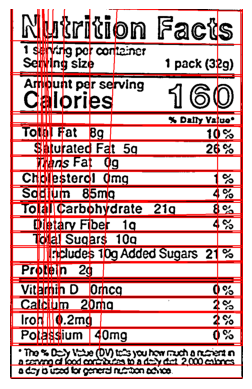

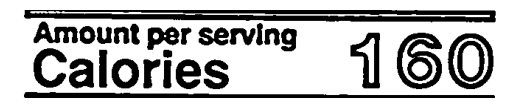

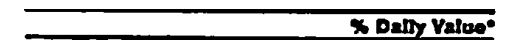

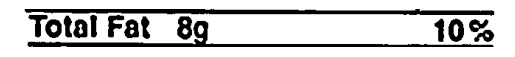

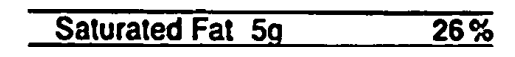

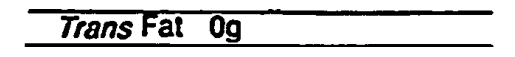

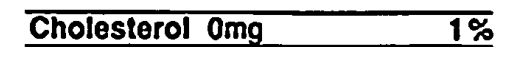

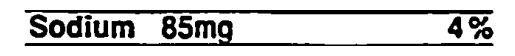

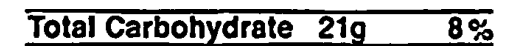

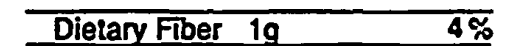

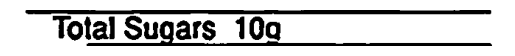

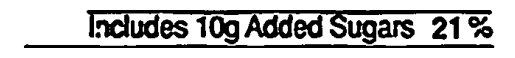

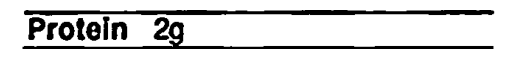

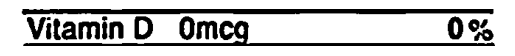

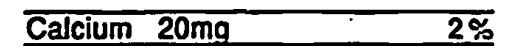

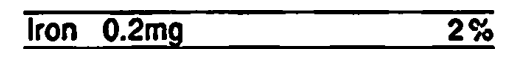

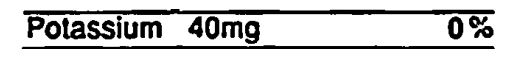

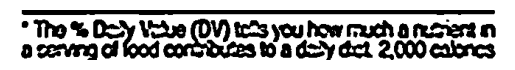

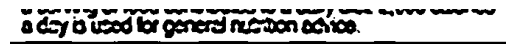

finished
elapsed: 1.671513209
Calories. 160

% Dally Vatue*

Total Fat 89 10%

Saturated Fat 5a 26%

Trans Fat 0g

Cholesterol Omg 1%

Sodium 85mg 4%

Total Carbohydrate 21g 8%

Dietary Fiber 1q 4%

Total Sugars 10a

Includes 10g Added Sugars 21%

Protein 24

Vitamin D Omeg 0%

Calcium 20ma . 2%

lron 0.2mg 2%

Potassium 40mg





In [274]:
#code up ocr shit now that we have the proper image cropped
#try to detect by zooming in
#clump words together by looking pixel density of characters next to ea other
# or maybe detect words and then if u can reasonably assume there is a correct label then u zoom in to its right side and see if u can more accurately get the value
for vimg in valid_images:
    res = scan_text(vimg)
    for line in res:
        print(line)